<a href="https://colab.research.google.com/github/NV2019/AERO_625_Platooning/blob/main/MC_Dissimilar_Neighborhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('patchwork')
install.packages('cowplot')
install.packages('wesanderson')

library(ggplot2)
library(patchwork) 
library(cowplot)
library(tidyverse)
library(wesanderson)
library(tidyverse)

# csv = 'data.csv'
# update.packages(ask = FALSE, checkBuilt = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0
✔ purrr   1.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
rm(list = ls())

# Asymmetry parameter
alpha_values <- 0:20

tol <- 3

# Total Simulation Time
FinalTime <- 300

Final_Mean_20_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_20_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_30_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_30_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_40_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_40_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_50_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_50_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_60_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_60_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_70_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_70_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_80_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_80_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_90_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_90_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_100_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_100_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_IPA <- matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Mean_OPA <-  matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Mean_Affect <-  matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Sd_IPA <- matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Sd_OPA <-  matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Sd_Affect <-  matrix(0,nrow=length(alpha_values),ncol=FinalTime)

MonteCarlo <- 100

MC_IPA <- matrix(0,nrow=MonteCarlo,ncol=FinalTime)

MC_OPA <-  matrix(0,nrow=MonteCarlo,ncol=FinalTime)

MC_Affect <-  matrix(0,nrow=MonteCarlo,ncol=FinalTime)

mapply(function(x){

  mapply(function(y){
    # -----------------------------------------------------------------------------------------------------------------------
    # Parameter Initialization
    # ----------------------------
      
    # Population Parameters

    # Group Size
    TotalPopulation <- 1000
    # Probability of an agent being left wing
    LeftWing <- 0.5
    # Probability of an agent being right wing
    RightWing <- 1.0-LeftWing
    # Probability of an agent being exposed to news from sources
    ExposureRate <- 0.01
    # Probability of an agent being exposed to retweets
    RetweetsExposure <- 0.5
    # Probability that an agent will retweet
    RetweetRate <- 1
    # All Possible slants
    Slants <- c(1,2)

    # Simulation Parameters
    # Asymmetry parameter
    alpha <- x

    # Network Parameters

    # Minimum degree of each node
    MinimumDegree <- 0.01*TotalPopulation
    # Maximum degree of each node
    MaximumDegree <- 0.1*TotalPopulation
    # Indices of nodes
    Nodes <- 1:TotalPopulation
    # Degree of each node
    NodeDegree <- sample(MinimumDegree:MaximumDegree,TotalPopulation,replace=TRUE,p=NULL)
    # Extent of similarity of slant in individual neighborhood
    NeighborhoodSimilarity <- 0

    # -----------------------------------------------------------------------------------------------------------------------
    # Placeholder Initialization
    # ----------------------------

    # Time Series Values: 1=MeanIPA, 2=MeanOPA, 3=MeanAffect
    MeanTimeSeriesValues <- matrix(0,nrow=5,ncol=FinalTime)
    # Matrix to store indices of neighbors
    NeighborsMatrix <- matrix(0,nrow = TotalPopulation,ncol=MaximumDegree)
    # Agent Attributes: 1=Slant, 2=IPA, 3=OPA, 4=NewsTargets, 5=SlantofNewsExposure, 
    # 6=ExposedStatus, 7=DifferenceinSlants, 8=Gain
    Agents <- matrix(0,nrow=TotalPopulation,ncol=10)
    Vectors <- matrix(0,nrow=TotalPopulation,ncol=10)
    # Slant
    Agents[,1] <- sample(1:2, TotalPopulation, replace = TRUE, prob = c(LeftWing,RightWing))
    # IPA
    Agents[,2] <- sample(50:70, TotalPopulation, replace = TRUE, prob = NULL)
    #OPA
    Agents[,3] <- sample(30:50, TotalPopulation, replace = TRUE, prob = NULL)

    # -----------------------------------------------------------------------------------------------------------------------
    # Constructing the similarity/dissimilarity network
    # --------------------------------------------------

    # Identifying slant of neighbors based on neighborhood_similarity parameter
    NeighborhoodSlant <- mapply(function(x){
      sample(c(Agents[x,1],Slants[Slants!=Agents[x,1]]),NodeDegree[x],replace=TRUE,p=c(NeighborhoodSimilarity,1-NeighborhoodSimilarity))},Nodes)
    mapply(function(x){
    # Identify the indices with slant 1
    if (length(which(NeighborhoodSlant[[x]]==1))!=0 & length(which(NeighborhoodSlant[[x]]==1))<NodeDegree[x]){
      NeighborsMatrix[x,1:length(which(NeighborhoodSlant[[x]]==1))] <<- sample(which(Agents[,1]==1)[which(Agents[,1]==1)!=x])[1:length(which(NeighborhoodSlant[[x]]==1))]
      # Identify the indices with slant 2
      NeighborsMatrix[x,(length(which(NeighborhoodSlant[[x]]==1))+1):NodeDegree[x]] <<- sample(which(Agents[,1]==2)[which(Agents[,1]==2)!=x])[1:length(which(NeighborhoodSlant[[x]]==2))]}
    else {
      if (length(which(NeighborhoodSlant[[x]]==1))==NodeDegree[x]){
        NeighborsMatrix[x,1:length(which(NeighborhoodSlant[[x]]==1))] <<- sample(which(Agents[,1]==1)[which(Agents[,1]==1)!=x])[1:length(which(NeighborhoodSlant[[x]]==1))]}
      else{
        NeighborsMatrix[x,1:length(which(NeighborhoodSlant[[x]]==2))] <<- sample(which(Agents[,1]==2)[which(Agents[,1]==2)!=x])[1:length(which(NeighborhoodSlant[[x]]==2))]}
    }},Nodes)

    for (t in 1:FinalTime){
      # print("Iteration,", t)
      # Mean IPA
      MeanTimeSeriesValues[1,t] <- mean(Agents[,2])
      # Mean OPA
      MeanTimeSeriesValues[2,t] <- mean(Agents[,3])
      # Affect
      MeanTimeSeriesValues[3,t] <- MeanTimeSeriesValues[1,t] - MeanTimeSeriesValues[2,t]

      # News Content
      Agents[,5] <- sample(1:2,TotalPopulation,replace=TRUE,prob=NULL)
      # News_Exposed
      Agents[,6] <- 0
      Agents[,6] <- (runif(TotalPopulation)<ExposureRate)
      # Not exposed to news, news content is 0
      Agents[Agents[,6]==0,5] <- 0
      # Retweeting Status 
      Vectors[,3] <- Agents[,7]
      # Retweet Exposure
      Vectors[,5] <- Agents[,8]
      # Reset exposure to retweets
      Agents[,8] <- 0

      # Difference
      # Update of those exposed to retweets/news previously
      Agents[,9] <- abs(Agents[,1] - Vectors[,4])
      # Gain
      Agents[,10] <- -alpha-10*(exp(2*(Agents[,9]-0.5))-1)/(exp(2*(Agents[,9]-0.5))+1)
      Agents[(Vectors[,5]==0)&(Vectors[,2]==0),10] <- 0
      # cat("Updating,", which(!((Vectors[,5]==0)&(Vectors[,2]==0))),"\n",sep="\t")
      #New IPA
      Agents[Agents[,10]>0,2] <- Agents[Agents[,10]>0,2] + Agents[Agents[,10]>0,10] 
      Agents[Agents[,2]>100,2] <- 100
      #New OPA
      Agents[Agents[,10]<0,3] <- Agents[Agents[,10]<0,3] + Agents[Agents[,10]<0,10]  
      Agents[Agents[,3]<0,3] <- 0

      # Retweet exposure
      temporary_neighbors_list <- mapply(function(x){
        # Store neighbors list for manipulation
        temporary_neighbors_list <- NeighborsMatrix
        # Rid neighbors exposed to news
        temporary_neighbors_list[x,which(Agents[temporary_neighbors_list[x,],6]==1)] <- 0
        # Rid neighbors exposed to retweaets
        temporary_neighbors_list[x,which(Vectors[temporary_neighbors_list[x,],5]==1)] <- 0    
        # Retweet Exposed
        Agents[temporary_neighbors_list[x,],8] <<- sample(0:1,length(which(temporary_neighbors_list[x,]!=0)),replace=TRUE,p=c(1-RetweetsExposure,RetweetsExposure))
        # Retweet Slant
        Agents[temporary_neighbors_list[x,which(Agents[temporary_neighbors_list[x,],8]==1)],4] <<- Vectors[x,4]
      },which(Vectors[,3]==1))

      # News Content
      Vectors[,1] <- Agents[,5]
      # Exposure
      Vectors[,2] <- Agents[,6]
      # cat("news exposure,", which(Vectors[,2]==1),"\n",sep="\t")
      # Retweeting Status
      Agents[,7] <- 0
      # Retweeting Content
      Agents[Agents[,8]==1,5] <- Agents[Agents[,8]==1,4]
      # cat("retweet exposure,", which(Agents[,8]==1),"\n",sep="\t")
      # Exposed to News/Retweets and Retweeting
      Agents[,7] <- ((runif(TotalPopulation)<RetweetRate) & (Agents[,1]==Agents[,5]) & ((Agents[,6]==1)|(Agents[,8]==1))) 
      # News and Retweeting Content
      Vectors[,4] <- Agents[,5]
      # cat("news or retweet exposure,", which(Agents[,7]==1),"\n",sep="\t")

    }

    MC_IPA[y,] <<- MeanTimeSeriesValues[1,]

    MC_OPA[y,] <<- MeanTimeSeriesValues[2,]

    MC_Affect[y,] <<- MeanTimeSeriesValues[3,]  

  },1:MonteCarlo)

Final_Mean_20_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-20)<=tol)[1]},1:MonteCarlo))

Final_Sd_20_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-20)<=tol)[1]},1:MonteCarlo))

Final_Mean_30_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-30)<=tol)[1]},1:MonteCarlo))

Final_Sd_30_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-30)<=tol)[1]},1:MonteCarlo))

Final_Mean_40_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-40)<=tol)[1]},1:MonteCarlo))

Final_Sd_40_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-40)<=tol)[1]},1:MonteCarlo))

Final_Mean_50_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-50)<=tol)[1]},1:MonteCarlo))

Final_Sd_50_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-50)<=tol)[1]},1:MonteCarlo))

Final_Mean_60_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-60)<=tol)[1]},1:MonteCarlo))

Final_Sd_60_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-60)<=tol)[1]},1:MonteCarlo))

Final_Mean_70_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-70)<=tol)[1]},1:MonteCarlo))

Final_Sd_70_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-70)<=tol)[1]},1:MonteCarlo))

Final_Mean_80_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-80)<=tol)[1]},1:MonteCarlo))

Final_Sd_80_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-80)<=tol)[1]},1:MonteCarlo))

Final_Mean_90_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-90)<=tol)[1]},1:MonteCarlo))

Final_Sd_90_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-90)<=tol)[1]},1:MonteCarlo))

Final_Mean_100_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_Affect[z,]-100)<=tol)[1]},1:MonteCarlo))

Final_Sd_100_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_Affect[z,]-100)<=tol)[1]},1:MonteCarlo))

Final_Mean_Time[x+1,] <<- mean(mapply(function(z){which(abs(MC_OPA[z,]-0)<=0.0001)[1]},1:MonteCarlo))

Final_Sd_Time[x+1,] <<- sd(mapply(function(z){which(abs(MC_OPA[z,]-0)<=0.0001)[1]},1:MonteCarlo))

Final_Mean_IPA[x+1,] <<- apply(MC_IPA,2,mean)

Final_Mean_OPA[x+1,] <<- apply(MC_OPA,2,mean)

Final_Mean_Affect[x+1,] <<- apply(MC_Affect,2,mean)

Final_Sd_IPA[x+1,] <<- apply(MC_IPA,2,sd)

Final_Sd_OPA[x+1,] <<- apply(MC_OPA,2,sd)

Final_Sd_Affect[x+1,] <<- apply(MC_Affect,2,sd)

},alpha_values)


0.2911589,0.2632654,0.2675240,0.2777945,0.2652568,0.2908590,0.2775648,0.2518040,0.2810062,0.2785602,⋯,0.2614735,0.3008772,0.2591235,0.2764542,0.2909141,0.2804472,0.2806244,0.2648822,0.2692593,0.2704520
0.2911589,0.2632654,0.2675240,0.2777945,0.2652568,0.2908590,0.2775648,0.2518040,0.2810062,0.2785602,⋯,0.2614735,0.3008772,0.2591235,0.2764542,0.2909141,0.2804472,0.2806244,0.2648822,0.2692593,0.2704520
0.2915615,0.2627902,0.2644680,0.2765214,0.2645052,0.2897477,0.2804639,0.2527714,0.2860917,0.2771341,⋯,0.2645129,0.3100205,0.2616109,0.2862367,0.2867477,0.2867245,0.2883044,0.2759174,0.2798761,0.2769724
0.4091640,0.4027438,0.4527673,0.5348101,0.5128642,0.5238274,0.5974204,0.6875966,0.7574295,0.7621059,⋯,1.0026971,0.9015177,0.9234060,0.9478160,0.9894543,1.0483457,1.2033849,1.2552077,1.3189216,1.2824273
0.4795565,0.5013054,0.5874047,0.6141274,0.6615567,0.6400073,0.7779896,0.9620675,0.8976074,1.0386465,⋯,1.2166603,1.2602443,1.2271882,1.1224065,1.3730624,1.3329871,1.6949355,1.5818196,1.7272898,1.7464766
0.4964755,0.5746148,0.6138936,0.7093122,0.7911657,0.8343832,0.9505879,1.0582539,1.0121207,1.1115491,⋯,1.4799166,1.5431656,1.4445220,1.3935471,1.6242804,1.7833846,1.7408981,1.7861902,1.9388257,1.8823892
0.5335347,0.6559065,0.6431910,0.7564266,0.8948459,0.9364844,1.0564874,1.2410628,1.2355942,1.3462942,⋯,1.5783920,1.6591953,1.6781716,1.7528394,1.7632399,2.1614686,1.9124549,1.9841941,1.9327030,1.9927807
0.5941722,0.7159595,0.7309962,0.8503120,0.9789469,0.9933728,1.0874836,1.2941768,1.3675301,1.5087921,⋯,1.6617390,1.8833632,1.8190052,1.8094487,1.8064939,2.3312920,1.9607154,2.0397566,2.0686216,2.1802883
0.6423877,0.7991442,0.7739746,0.9377881,1.0145231,1.0624196,1.1640859,1.4855919,1.5689877,1.5646016,⋯,1.7121636,1.9782680,1.7910026,2.0020708,1.9079953,2.4504056,2.0308456,2.0060615,2.1955966,2.1402409
0.6959972,0.8462075,0.8472676,0.9789556,1.0466531,1.1599425,1.2123423,1.5172735,1.5958416,1.7608161,⋯,1.8479269,2.0983591,1.8482942,2.1220126,1.9031990,2.5061826,2.0855438,1.9817994,2.0298894,2.0571845
0.7375375,0.8864969,0.9003178,0.9727749,1.1525875,1.2608342,1.2559886,1.5407179,1.6592319,1.9490044,⋯,1.9518061,2.2098368,2.0503328,2.1629500,2.0839194,2.5656584,2.1455779,1.9067292,2.0449043,2.1369127


In [3]:
write.csv(Final_Mean_IPA , file = "Dissimilar_Mean_IPA.csv")
write.csv(Final_Mean_OPA , file = "Dissimilar_Mean_OPA.csv")
write.csv(Final_Mean_Affect , file = "Dissimilar_Mean_Affect.csv")
write.csv(Final_Mean_Time , file = "Dissimilar_Mean_Time.csv")
write.csv(Final_Mean_Time , file = "Dissimilar_Mean_Time20.csv")
write.csv(Final_Mean_20_Time , file = "Dissimilar_Mean_Time20.csv")
write.csv(Final_Mean_30_Time , file = "Dissimilar_Mean_Time30.csv")
write.csv(Final_Mean_40_Time , file = "Dissimilar_Mean_Time40.csv")
write.csv(Final_Mean_50_Time , file = "Dissimilar_Mean_Time50.csv")
write.csv(Final_Mean_60_Time , file = "Dissimilar_Mean_Time60.csv")
write.csv(Final_Mean_70_Time , file = "Dissimilar_Mean_Time70.csv")
write.csv(Final_Mean_80_Time , file = "Dissimilar_Mean_Time80.csv")
write.csv(Final_Mean_90_Time , file = "Dissimilar_Mean_Time90.csv")
write.csv(Final_Mean_100_Time , file = "Dissimilar_Mean_Time100.csv")

write.csv(Final_Sd_IPA , file = "Dissimilar_Sd_IPA.csv")
write.csv(Final_Sd_OPA , file = "Dissimilar_Sd_OPA.csv")
write.csv(Final_Sd_Affect , file = "Dissimilar_Sd_Affect.csv")
write.csv(Final_Sd_Time , file = "Dissimilar_Sd_Time.csv")
write.csv(Final_Sd_20_Time , file = "Dissimilar_Sd_Time20.csv")
write.csv(Final_Sd_30_Time , file = "Dissimilar_Sd_Time30.csv")
write.csv(Final_Sd_40_Time , file = "Dissimilar_Sd_Time40.csv")
write.csv(Final_Sd_50_Time , file = "Dissimilar_Sd_Time50.csv")
write.csv(Final_Sd_60_Time , file = "Dissimilar_Sd_Time60.csv")
write.csv(Final_Sd_70_Time , file = "Dissimilar_Sd_Time70.csv")
write.csv(Final_Sd_80_Time , file = "Dissimilar_Sd_Time80.csv")
write.csv(Final_Sd_90_Time , file = "Dissimilar_Sd_Time90.csv")
write.csv(Final_Sd_100_Time , file = "Dissimilar_Sd_Time100.csv")

In [4]:
d_m_i<- read.csv("Dissimilar_Mean_IPA.csv")
d_m_o<- read.csv("Dissimilar_Mean_OPA.csv")
d_m_a<- read.csv("Dissimilar_Mean_Affect.csv")
d_m_t<- read.csv("Dissimilar_Mean_Time.csv")
d_m_t20<- read.csv("Dissimilar_Mean_Time20.csv")
d_m_t30<- read.csv("Dissimilar_Mean_Time30.csv")
d_m_t40<- read.csv("Dissimilar_Mean_Time40.csv")
d_m_t50<- read.csv("Dissimilar_Mean_Time50.csv")
d_m_t60<- read.csv("Dissimilar_Mean_Time60.csv")
d_m_t70<- read.csv("Dissimilar_Mean_Time70.csv")
d_m_t80<- read.csv("Dissimilar_Mean_Time80.csv")
d_m_t90<- read.csv("Dissimilar_Mean_Time90.csv")
d_m_t100<- read.csv("Dissimilar_Mean_Time100.csv")

d_s_i<- read.csv("Dissimilar_Sd_IPA.csv")
d_s_o<- read.csv("Dissimilar_Sd_OPA.csv")
d_s_a<- read.csv("Dissimilar_Sd_Affect.csv")
d_s_t<- read.csv("Dissimilar_Sd_Time.csv")
d_s_t20<- read.csv("Dissimilar_Sd_Time20.csv")
d_s_t30<- read.csv("Dissimilar_Sd_Time30.csv")
d_s_t40<- read.csv("Dissimilar_Sd_Time40.csv")
d_s_t50<- read.csv("Dissimilar_Sd_Time50.csv")
d_s_t60<- read.csv("Dissimilar_Sd_Time60.csv")
d_s_t70<- read.csv("Dissimilar_Sd_Time70.csv")
d_s_t80<- read.csv("Dissimilar_Sd_Time80.csv")
d_s_t90<- read.csv("Dissimilar_Sd_Time90.csv")
d_s_t100<- read.csv("Dissimilar_Sd_Time100.csv")

ERROR: ignored

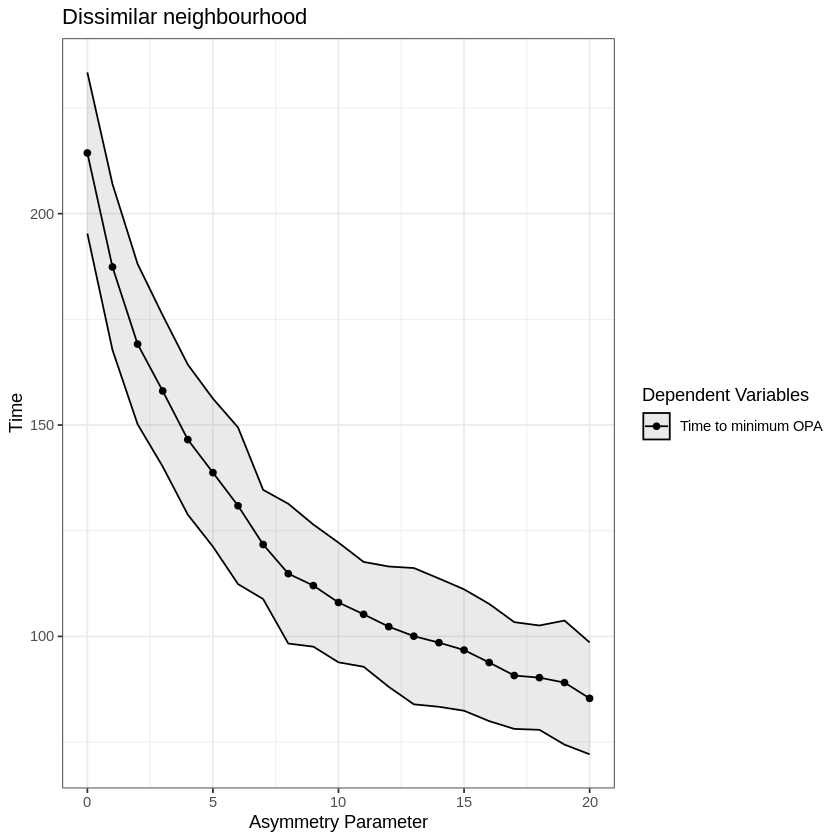

In [5]:
new_data <- tibble(0:20,d_m_t$V1)
new_data<-new_data %>%
  rename("Asymmetry" = 1)
new_data<-new_data %>%
  rename("Time" = 2)
colors <- c("Time to minimum OPA" = "black")
lower <- d_m_t$V1-d_s_t$V1
upper <- d_m_t$V1+d_s_t$V1

figure <-ggplot(data=new_data,aes(x=Asymmetry,y=Time,colour="Time to minimum OPA",group="Time to minimum OPA"))+
        geom_ribbon(aes(x=Asymmetry,ymin=lower,
                      ymax=upper),alpha=0.1) +  
  geom_point()+  
    geom_line()+
      labs(x="Asymmetry Parameter",y="Time",title="Dissimilar neighbourhood") + 
      scale_color_manual(name = "Dependent Variables",
                        values = colors)+
      theme_bw()

print(figure)

ggsave(filename = "dissimilar_time.svg", plot = figure, width = 5, height = 3)


In [11]:
d_m_t70

X,V1
<int>,<lgl>
1,NA
2,NA
3,NA
4,NA
5,NA
6,NA
7,NA
8,NA
9,NA
